## Predicting NYC Yellow Taxi Fares
Analysis of NYC Yellow Taxi from January through June 2017. The purpose of this analysis is to identify trends and attempt to predict price of a trip using Yellow Taxi. Random samples of 1000 rows were taken from each month's full dataset. The source of the data is http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml. 

## Setup and EDA

In [31]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
jan = pd.read_excel(open('YellowTaxiJan2017Samp.xlsx','rb'))
feb = pd.read_csv('YellowTaxiFeb2017Samp.csv')
mar = pd.read_excel(open('YellowTaxiMar2017Samp.xlsx','rb'))
apr = pd.read_excel(open('YellowTaxiApr2017Samp.xlsx', 'rb'))
may = pd.read_csv('YellowTaxiMay2017Samp.csv')
jun = pd.read_csv('YellowTaxiJune2017Samp.csv')
# remove irrelevant columns
# Note: some of this was cleaned up in Excel
feb.drop(['store_and_fwd_flag'], axis = 1, inplace = True)
jun.drop(['store_and_fwd_flag'], axis = 1, inplace = True)
YelTax_2017_1sthalf = pd.concat([jan,feb,mar,apr,may,jun]).reset_index(drop=True)
print(YelTax_2017_1sthalf.columns)
YelTax_2017_1sthalf.describe()

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.547000,1.661500,2.866147,1.039167,161.965000,158.882000,1.347000,12.657457,0.339920,0.497583,1.767413,0.302772,0.299550,15.869270
std,0.497828,1.296224,3.676199,0.279843,66.847943,70.485264,0.505932,11.485926,0.466225,0.038115,2.426411,1.409167,0.014994,14.053432
min,1.000000,1.000000,0.000000,1.000000,4.000000,1.000000,1.000000,-52.000000,-0.500000,-0.500000,-1.890000,0.000000,-0.300000,-52.800000
25%,1.000000,1.000000,0.960000,1.000000,113.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.000000,1.600000,1.000000,162.000000,161.000000,1.000000,9.000000,0.000000,0.500000,1.310000,0.000000,0.300000,11.750000
75%,2.000000,2.000000,3.000000,1.000000,233.000000,231.250000,2.000000,14.000000,0.500000,0.500000,2.350000,0.000000,0.300000,17.160000
max,2.000000,6.000000,46.180000,5.000000,265.000000,265.000000,4.000000,250.000000,4.500000,0.500000,46.960000,18.500000,0.300000,266.560000


The mean fare amount is 12.81 and the mean distance traveled is 2.9 miles (based on the initial data). 

In [32]:
# Convert columns to snake case
YelTax_2017_1sthalf.columns = ['vendor_ID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'rate_code_ID', 'pu_location_ID',
       'do_location_ID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']

In [33]:
# Take a look at the rate code frequencies
rate_codes = {1: 'Standard Rate', 2: 'JFK', 3: 'Newark', 4: 'Nassau or Westchester', 5:'Negotiated fare', 6:'Group ride'} # dictionary of values to convert
rate_code_summary = pd.Series(YelTax_2017_1sthalf['rate_code_ID'].values) # create the series
rate_code_summary.replace(rate_codes, inplace = True)
print(rate_code_summary.value_counts())

Standard Rate            5834
JFK                       134
Negotiated fare            16
Newark                     11
Nassau or Westchester       5
dtype: int64


According to the sample data, there were no group rides. However, there were rides with more than 1 passenger in the sample data. For the majority of rides (5834 out of 6000), the standard rate was applied. 

In [34]:
# Look at pay type frequencies
pay_type = {1: 'Credit Card', 2: 'Cash', 3: 'No Charge', 4: 'Dispute', 5:'Unknown', 6:'Voided Trip'} # dictionary of values to convert
pay_type_summary = pd.Series(YelTax_2017_1sthalf['payment_type'].values) # create the series
pay_type_summary.replace(pay_type, inplace = True)
print(pay_type_summary.value_counts())

Credit Card    3989
Cash           1957
No Charge        37
Dispute          17
dtype: int64


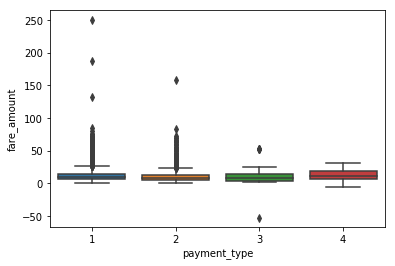

In [35]:
# Can payment type have a relationship with fare amount?
c = sns.boxplot(x="payment_type", y="fare_amount", data=YelTax_2017_1sthalf)

The above boxplot reveals that the method of payment would not be a good predictor of fare amount. 

In [36]:
# Create a cost per mile attribute to better understand how relevant attributes affect the fare amount.
YelTax_2017_1sthalf['cost_per_mile'] = (YelTax_2017_1sthalf['fare_amount'])/(YelTax_2017_1sthalf['trip_distance'])

In [37]:
YelTax_2017_1sthalf.head()

,vendor_ID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_ID,pu_location_ID,do_location_ID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,cost_per_mile
0,2,2017-01-16 16:29:48,2017-01-16 16:46:45,6,3.94,1,237,151,2,16.0,0.0,0.5,0.00,0.00,0.3,16.80,4.060914
1,2,2017-01-14 23:01:43,2017-01-14 23:37:37,1,19.49,2,141,132,1,52.0,0.0,0.5,10.00,5.54,0.3,68.34,2.668035
2,1,2017-01-01 11:28:26,2017-01-01 11:39:38,2,4.40,1,261,148,1,15.0,0.0,0.5,3.15,0.00,0.3,18.95,3.409091
3,1,2017-01-15 22:27:57,2017-01-15 22:35:01,1,1.00,1,107,170,1,6.5,0.5,0.5,1.00,0.00,0.3,8.80,6.500000
4,1,2017-01-16 18:13:08,2017-01-16 18:32:44,2,5.20,1,41,143,2,19.0,0.0,0.5,0.00,0.00,0.3,19.80,3.653846


As the primary purpose of this analysis is to predict fares, I remove unusual cases, as well as no charges and disputes. I also remove anything less than 0 for fare amount. As unusual costs per mile were revealed, I infer that anything above 20 for cost per mile is an outlier. 

In [38]:
YelTax_2017_1sthalf.replace([np.inf, -np.inf], np.nan)
YelTax_2017_1sthalf = YelTax_2017_1sthalf.replace([np.inf, -np.inf], np.nan).dropna()
YelTax_2017_1sthalf = YelTax_2017_1sthalf[YelTax_2017_1sthalf.fare_amount > 0] # removing outliers
YelTax_2017_1sthalf = YelTax_2017_1sthalf[YelTax_2017_1sthalf.payment_type != 4] # no charge and dispute cases removed
YelTax_2017_1sthalf = YelTax_2017_1sthalf[YelTax_2017_1sthalf.payment_type != 3]
YelTax_2017_1sthalf = YelTax_2017_1sthalf[YelTax_2017_1sthalf.cost_per_mile < 20] # assumption is anything above 20 per mile is out of the norm
YelTax_2017_1sthalf.describe()

,vendor_ID,passenger_count,trip_distance,rate_code_ID,pu_location_ID,do_location_ID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,cost_per_mile
count,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5.882000e+03,5882.000000,5882.000000
mean,1.551853,1.665250,2.897829,1.031622,162.131758,158.952227,1.326590,12.601836,0.338749,0.498555,1.775595,0.299036,3.000000e-01,15.818438,5.879218
std,0.497346,1.299541,3.682982,0.231846,66.765117,70.381429,0.469006,11.055863,0.455238,0.026844,2.340182,1.399883,2.992305e-14,13.565780,2.253901
min,1.000000,1.000000,0.180000,1.000000,4.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000e-01,3.800000,1.645049
25%,1.000000,1.000000,1.000000,1.000000,113.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,3.000000e-01,8.300000,4.329430
50%,2.000000,1.000000,1.620000,1.000000,162.000000,161.000000,1.000000,9.000000,0.000000,0.500000,1.350000,0.000000,3.000000e-01,11.760000,5.454545
75%,2.000000,2.000000,3.000000,1.000000,233.000000,231.000000,2.000000,14.000000,0.500000,0.500000,2.360000,0.000000,3.000000e-01,17.160000,6.882127
max,2.000000,6.000000,46.180000,5.000000,265.000000,265.000000,2.000000,250.000000,4.500000,0.500000,27.810000,18.500000,3.000000e-01,266.560000,19.444444


Initial assumption is that distance has the most correlation with fare amount, let's visualize this. 

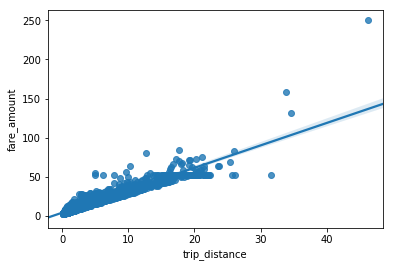

In [39]:
a = sns.regplot('trip_distance','fare_amount',data = YelTax_2017_1sthalf)

In [40]:
pearson_coef, p_value = stats.pearsonr(YelTax_2017_1sthalf['trip_distance'], YelTax_2017_1sthalf['fare_amount'])
print(pearson_coef, p_value)

0.9549662170007814 0.0


Based on the above chart and pearson correlation analysis, the pearson correlation coefficient and p-value confirm a strong relationship between distance and fare amount. Next I will see if passenger count may impact fare amount. 

In [41]:
pearson_coef, p_value = stats.pearsonr(YelTax_2017_1sthalf['passenger_count'], YelTax_2017_1sthalf['fare_amount'])
print(pearson_coef, p_value)

0.019853294722594148 0.1278941248889989


Passenger count has little relationship to fare amount.

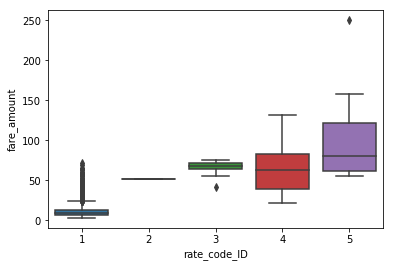

In [42]:
# Rate code ID vs fare amount
b = sns.boxplot(x="rate_code_ID", y="fare_amount", data=YelTax_2017_1sthalf)

According to the boxplot, rate codes seem to affect fares by some degree. Let's go into this further.

In [43]:
# Review the means of each rate code and fare amount. ANOVA test could also be implemented here.
rate_test=YelTax_2017_1sthalf[['rate_code_ID','fare_amount']]
rate_test=rate_test.groupby(['rate_code_ID'],as_index= True).mean()
print(rate_test)

              fare_amount
rate_code_ID             
1               11.505403
2               52.000000
3               65.636364
4               68.000000
5              107.428571


The means present an argument for rate codes to be predictors for fare amounts. Let's review this further. 

In [44]:
rate_code_1 = YelTax_2017_1sthalf[YelTax_2017_1sthalf.rate_code_ID == 1]
rate_code_1.trip_distance.mean()

2.5142558382711813

In [45]:
rate_code_1.cost_per_mile.mean()

5.945738771343789

Rate code 1 appears to the the applied rate for standard commutes.

In [46]:
rate_code_2 = YelTax_2017_1sthalf[YelTax_2017_1sthalf.rate_code_ID == 2]

In [47]:
rate_code_2.trip_distance.mean()

17.998181818181816

In [48]:
rate_code_2.cost_per_mile.mean()

3.0263445321772156

Rate code 2 is JFK. The average trip was over 17 miles long in duration. However, the cost per mile mean is lower than the standard rate mean.

In [49]:
rate_code_3 = YelTax_2017_1sthalf[YelTax_2017_1sthalf.rate_code_ID == 3]

In [50]:
rate_code_3.trip_distance.mean()

16.975454545454543

In [51]:
rate_code_3.cost_per_mile.mean()

3.929528584070658

Rate code 3 is negotiated fares, appears to apply to longer trips as well. The cost per mile mean is also lower than the standard rate mean.

In [52]:
rate_code_4 = YelTax_2017_1sthalf[YelTax_2017_1sthalf.rate_code_ID == 4]
rate_code_4.trip_distance.mean()

20.166000000000004

In [53]:
rate_code_4.cost_per_mile.mean()

3.2729728918194767

Rate code 4 also applies to longer trips, and the cost per mile mean is lower than the standard rate mean.

In [54]:
rate_code_5 = YelTax_2017_1sthalf[YelTax_2017_1sthalf.rate_code_ID == 5]
rate_code_5.trip_distance.mean()

21.841428571428573

In [55]:
rate_code_5.cost_per_mile.mean()

5.5904546899255125

Rate code 5 applies to trips to Nassau or Westchester. These are fairly long trips as well. The mean cost per mile is higher than the other categories, however there are only 9 observations in this category. In summary, rate codes 2-5 apply to longer duration trips including to airports. It is assumed that the standard rate is applied to short distance trips. This could be cases such as people going to work, a meeting, or for going to restuarants/nightlife within the city. In conclusion, the rate codes and distance have the most impact on fares. Payment method does not have a significant effect. 

## Modeling...

In [57]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Linear Regression: Distance against Fare

In [58]:
d = YelTax_2017_1sthalf[['trip_distance']] # double brackets for the independent variable
e = YelTax_2017_1sthalf['fare_amount']
d = d/d.max() # scale the data
e = e/e.max()
lm.fit(d,e)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
lm.coef_ # slope

array([0.52953542])

In [60]:
lm.intercept_ # y intercept

0.017178607178900074

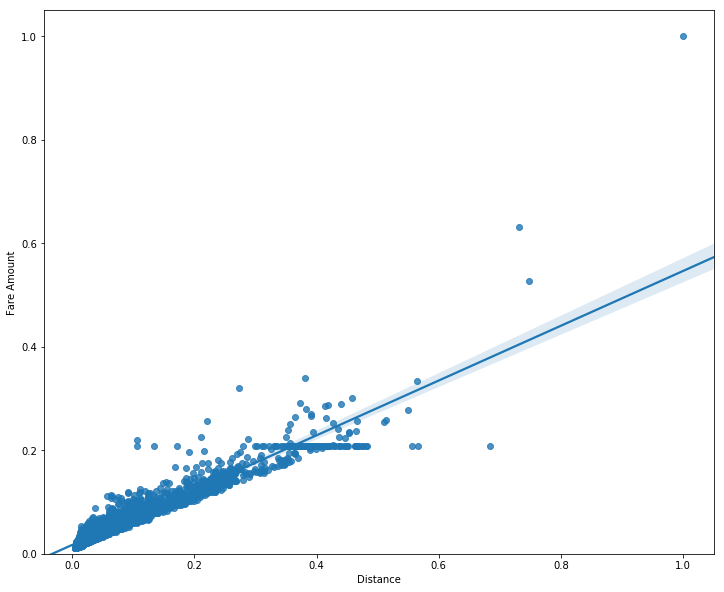

In [67]:
# Linear regression plot
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(d, e, data=YelTax_2017_1sthalf)
plt.xlabel('Distance')
plt.ylabel('Fare Amount')
plt.ylim(0,)
plt.show()

## Multiple Regression

In [78]:
dums = pd.get_dummies(YelTax_2017_1sthalf['rate_code_ID'], prefix = 'rt')

In [79]:
td_fa = YelTax_2017_1sthalf[['trip_distance', 'fare_amount']]

In [80]:
# scale the data
mlr_df = pd.concat([td_fa, dums], axis=1, join_axes=[td_fa.index])
mlr_df.head()
mlr_df['trip_distance'] = mlr_df['trip_distance']/mlr_df['trip_distance'].max()
mlr_df['fare_amount'] = mlr_df['fare_amount']/mlr_df['fare_amount'].max()

In [81]:
# drop one of the rate codes 
Z = mlr_df[['rt_1', 'rt_2', 'rt_3', 'rt_4', 'trip_distance']]
Z.head()

,rt_1,rt_2,rt_3,rt_4,trip_distance
0,1,0,0,0,0.085318
1,0,1,0,0,0.422044
2,1,0,0,0,0.095279
3,1,0,0,0,0.021654
4,1,0,0,0,0.112603


In [82]:
Z.describe()

,rt_1,rt_2,rt_3,rt_4,trip_distance
count,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000
mean,0.975519,0.020571,0.001870,0.000850,0.062751
std,0.154552,0.141956,0.043208,0.029146,0.079753
min,0.000000,0.000000,0.000000,0.000000,0.003898
25%,1.000000,0.000000,0.000000,0.000000,0.021654
50%,1.000000,0.000000,0.000000,0.000000,0.035080
75%,1.000000,0.000000,0.000000,0.000000,0.064963
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
Y = mlr_df['fare_amount']

In [84]:
#Backwards elimination
import statsmodels.formula.api as sm
# Added a column of 1's for backward elimination process
X = np.append(arr = np.ones((5882,1)).astype(int), values = Z, axis = 1)

In [85]:
X[0:2]

array([[1.        , 1.        , 0.        , 0.        , 0.        ,
        0.08531832],
       [1.        , 0.        , 1.        , 0.        , 0.        ,
        0.42204417]])

In [86]:
X_opt = X[:, [0,1,2,3,4,5]]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit() # fit OLS to X_opt and Y
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.642e+04
Date:                Wed, 19 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:19:21   Log-Likelihood:                 17956.
No. Observations:                5882   AIC:                        -3.590e+04
Df Residuals:                    5876   BIC:                        -3.586e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1807      0.004     40.345      0.000       0.172       0.189
x1            -0.1633      0.004    -36.724      0.000      -0.172      -0.155
x2            -0.1779      0.004    -39.981      0.000      -0.187      -0.169
x3            -0.1117      0.006    -20.181      0.000      -0.123      -0.101
x4            -0.1386      0.007    -20.703      0.000      -0.152      -0.125
x5             0.5265      0.002    211.910      0.000       0.522       0.531
==============================================================================
Omnibus:                     5400.672   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2798939.225
Skew:                           3.478   Prob(JB):                         0.00
Kurtosis:                     109.639   Cond. No.                         95.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The independent variables appear reliable. No elimination is needed. 

In [87]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Z, Y, test_size = 0.2, random_state = 0) # X is indepdent var, Y is dependen

C:\Users\martl\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [88]:
#Fitting MLR to the trng set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [89]:
# Predicted results
Y_pred = regressor.predict(X_test) # predict observations from test set
Y_pred[:5]

array([0.03950421, 0.20052035, 0.03328025, 0.05172161, 0.1960208 ])

In [90]:
# Actual results
Y_test[:5]

1579    0.052
1355    0.180
1191    0.036
3898    0.058
4825    0.208
Name: fare_amount, dtype: float64

The predictions are fair. 

In [92]:
lm.fit(Z, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [93]:
lm.intercept_

0.18067859710865639

In [94]:
lm.coef_

array([-0.1633245 , -0.17789364, -0.11168706, -0.13861107,  0.52654377])

In [95]:
# Y_hat = lm.predict(Z)
Y_hat = Y_pred # using the train/test setup

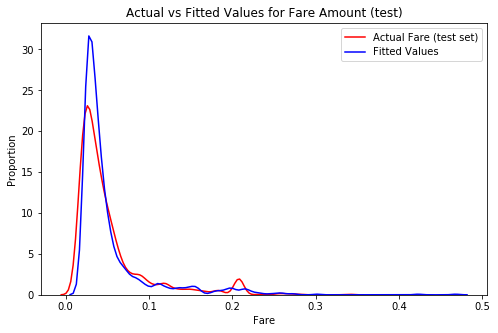

In [96]:
# plt.figure() # using the train test sets to plot

fig = plt.figure(figsize = (8,5))
ax1 = sns.distplot(Y_test, hist=False, color="r", label="Actual Fare (test set)")
# ax1 = sns.distplot(YelTax_2017_1sthalf['fare_amount'], hist=False, color="r", label="Actual Fare (test set)") # not using train/test
sns.distplot(Y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Fare Amount (test)')
plt.xlabel('Fare')
plt.ylabel('Proportion')

plt.show()
plt.close()

MLR results, not too bad.

## Polynomial Regression...

In [98]:
# Polynomial regression plot
def PlotPolly(model,independent_variable,dependent_variable, Name):
    x_new = np.linspace(0, 1, 100)
    y_new = model(x_new)

    plt.plot(independent_variable,dependent_variable,'.', x_new, y_new, '-')
    plt.title('Polynomial Fit')
    ax = plt.gca()
#     ax.set_axis_bgcolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Fare Amount')

    plt.show()
    plt.close()

In [99]:
x = YelTax_2017_1sthalf['trip_distance']
y = YelTax_2017_1sthalf['fare_amount']
x = x/x.max()
y = y/y.max()

In [100]:
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

     3         2
1.4 x - 1.185 x + 0.7514 x + 0.01112


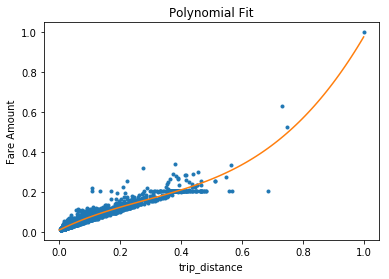

In [101]:
PlotPolly(p,x,y, 'trip_distance')

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [103]:
pr=PolynomialFeatures(degree=2)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

## Evaluate the Models

Linear Regression...

In [104]:
#highway_mpg_fit
lm.fit(d, e)
# Find the R^2
lm.score(d, e)

0.9119604756127838

In [105]:
Yhat=lm.predict(d)

In [106]:
mean_squared_error(e, Yhat)

0.00017215082761549115

MLR...

In [107]:
# fit the model 
lm.fit(Z, Y)
# Find the R^2
lm.score(Z, Y)

0.9332146901167924

In [108]:
Y_predict_multifit = lm.predict(Z)

In [109]:
mean_squared_error(Y, Y_predict_multifit)

0.00013059073693292975

Polynomial Regression...

In [112]:
r_squared = r2_score(e, p(x))
r_squared

0.937625407081988

In [113]:
mean_squared_error(e, p(x))

0.0001219661040623964

## Polynomial regression is the model of choice according to the r-squared and MSE. 